## Frequency response of 2D-waveguide

In [12]:
import fenics as fen
import mshr
import helpers
import numpy as np
import matplotlib.pyplot as plt
import wg2D
import scipy.sparse
import scipy.sparse.linalg

In [13]:
def get_solution_L2_norms(omegas, K, M, L, bc, V):
    L2_norms = np.empty(len(omegas))
    F = fen.assemble(fen.dot(fen.TrialFunction(V), fen.TestFunction(V))*fen.dx)
    F_mat = fen.as_backend_type(F).mat()
    F_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(F_mat.getValuesCSR()[::-1]))
    for i, omega in enumerate(omegas):
        A_z = wg2D.solve(omega, K, M, L, bc, V).vector().get_local()
        L2_norms[i] = pow(A_z.T @ F_sparse @ A_z, 0.5)
    return L2_norms

In [14]:
def get_analytical_eigenvalues(Lx, Ly, a, b):
    freqs = lambda n, m: np.pi*pow(n**2/(Lx)**2 + (m+0.5)**2/(Ly)**2 , 0.5)
    n_max = np.ceil(b * Lx / np.pi).astype('int')
    m_max = np.ceil(b * Ly / np.pi - 0.5).astype('int')
    eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(1, n_max+1), range(m_max+1)))
    return [x for x in eigs if a <= x and x <= b]

### Create waveguide and set boundary conditions

In [15]:
Lx = 5.0
Ly = 1.0
domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly))
mesh = mshr.generate_mesh(domain, 64)

mu = fen.Expression('1.0', degree=2) # 4*np.pi*1e-7 # magnetic permeability inside waveguide
eps = fen.Expression('1.0', degree=2) # 8.854187e-12 # electric permittivity inside waveguide
g_z_inlet = fen.Expression('1.0', degree=2)

# Define location of inlet
class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0) and x[1]>0 and x[1]<Ly

boundary, V, bc = wg2D.create(mesh, Inlet())

### Get stiffness and mass matrices and add forcing term

In [16]:
K, M, L = wg2D.setup(boundary, g_z_inlet, mu, eps, V)

### Observe frequency response

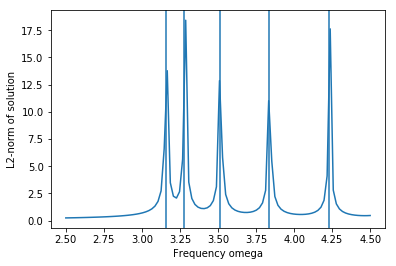

In [17]:
omegas = np.linspace(2.5, 4.5, 100)

# L2 norm of solution for many different frequencies
L2_norms =  get_solution_L2_norms(omegas, K, M, L, bc, V)
plt.plot(omegas, L2_norms)
plt.xlabel('Frequency omega')
plt.ylabel('L2-norm of solution')

# Expected location of peaks
eigs = get_analytical_eigenvalues(1.0, 5.0, omegas[0], omegas[-1])
[plt.axvline(x) for x in eigs]
plt.show()

### First resonant solution

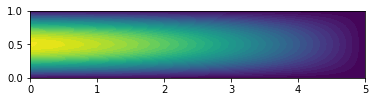

In [18]:
omega = eigs[0]
A_z = wg2D.solve(omega, K, M, L, bc, V)
fen.plot(A_z)
plt.show()

### Third resonant solution

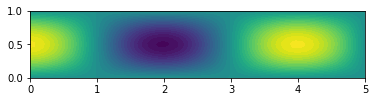

In [19]:
omega = eigs[2]
A_z = wg2D.solve(omega, K, M, L, bc, V)
fen.plot(A_z)
plt.show()

## Unforced waveguide

### Compute eigenvalues numerically (for unforced system)

In [20]:
K_mat = fen.as_backend_type(fen.assemble(K)).mat()
K_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(K_mat.getValuesCSR()[::-1]))
M_mat = fen.as_backend_type(fen.assemble(M)).mat()
M_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(M_mat.getValuesCSR()[::-1]))

# ev = scipy.sparse.linalg.eigsh(K_sparse, k=1, M=M_sparse, which='SM') <- This doesn't work
#      It seems as if the smallest eigenvalue (which apparently turns out to be 0) can not be
#      iterated with which='SM'. Using the shift-invert mode seems to fix this problem.
ev = scipy.sparse.linalg.eigsh(K_sparse, k=4, M=M_sparse, sigma=0.01)[0]

# Setting eigenvalues close to machine epsilon to 0.0 since they are 
# usually not exactly iterated, and sometimes even negative
ev[ev < 1e-14] = 0.0
print(np.sqrt(ev))

[ 0.          0.62834107  1.25681558  1.88557174]


### Compute eigenvalues analytically (for unforced system)

In [21]:
freqs = lambda n, m: np.pi*pow(n**2/Lx**2 + m**2/Ly**2 , 0.5)
eigs = np.sort(np.frompyfunc(freqs, 2, 1).outer(range(10), range(10)).flatten())[:4]
print(eigs)

[0.0 0.6283185307179586 1.2566370614359172 1.8849555921538759]
